## Workshop 11. Diffusion Model 

**Sources:**
- Youtube [Diffusion models from scratch in PyTorch](https://www.youtube.com/watch?v=a4Yfz2FxXiY)
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- https://m0nads.wordpress.com/2021/07/17/diffusion-models/
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)

## Generating images with DDPMs: A PyTorch Implementation

Denoise Diffusion Probabilistic Models (DDPMs) are generative models based on the idea of reversing a noising process. The idea is fairly simple: Given a dataset, make it more and more noisy with a deterministic process. Then, learn a model that can undo this process.

DDPM-based models have recently drawn a lot of attention due to their high-quality samples. In this notebook, I re-implement the first and most fundamental paper to be familiar with when dealing with DDPMs: <i>Denoising Diffusion Probabilistic Models</i> (https://arxiv.org/pdf/2006.11239.pdf) by Ho et. al.

**Check out the GitHub Repository** (https://github.com/BrianPulfer/PapersReimplementations/tree/master/ddpm) to get .py files that you can use in other projects.

In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import random
import imageio
import numpy as np
from argparse import ArgumentParser

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import einops
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets.mnist import MNIST, FashionMNIST

In [ ]:
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Lambda(lambda x: (x - 0.5) * 2)]
)

batch_size = 128
# ds_fn = FashionMNIST
dataset = MNIST("./datasets", download=True, train=True, transform=transform)

train_data = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Шаг 1: Прямой процесс = Noise scheduler

В дифузионных моделях праямым процессом (forward) называется добавление шума к модели 

![](https://s0.wp.com/latex.php?latex=%5Cdisplaystyle+q%28x_t+%5Cmid+x_%7Bt-1%7D%29+%3A%3D+%5Cmathcal%7BN%7D%28x_t%3B+%5Csqrt%7B1-%5Cbeta_t%7D+x_%7Bt-1%7D%2C+%5Cbeta_t%5Cmathbf%7BI%7D%29++&bg=ffffff&fg=000000&s=1&c=20201002&zoom=4)

![](https://s0.wp.com/latex.php?latex=%5Cdisplaystyle+q%28x_1%2C%5Cdots%2Cx_T+%5Cmid+x_0%29+%3A%3D+%5Cprod_%7Bt%3D1%7D%5ET+q%28x_t+%5Cmid+x_%7Bt-1%7D%29++&bg=ffffff&fg=000000&s=1&c=20201002&zoom=4)

Мы можем свернуть верхнее уравнение в простой гауссиан:

![](https://s0.wp.com/latex.php?latex=%5Cdisplaystyle+q%28x_t+%5Cmid+x_0%29+%3D++%5Cmathcal%7BN%7D%28x_t%3B+%5Csqrt%7B%5Coverline%7B%5Calpha%7D_t%7Dx_0%2C+%281-%5Coverline%7B%5Calpha%7D_t%29+%5Cmathbf%7BI%7D%29++&bg=ffffff&fg=000000&s=1&c=20201002&zoom=4)

Где 

![](https://s0.wp.com/latex.php?latex=%5Cdisplaystyle+%5Calpha_t+%3A%3D+1+-+%5Cbeta_t%2C+%5Cquad+%5Coverline%7B%5Calpha%7D_t+%3A%3D++%5Cprod_%7Bs%3D0%7D%5Et+%5Calpha_s%5C%2C%2C++&bg=ffffff&fg=000000&s=1&c=20201002&zoom=4)


In [ ]:
class ForwardModel:
    def __init__(self, min_beta, max_beta, time_steps_number, device):
        self.betas = torch.linspace(min_beta, max_beta, time_steps_number)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([
            torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))
        ]).to(device)

        self.device = device

    def forward(self, x0, t, eta=None):
        b_s, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(b_s, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(b_s, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(b_s, 1, 1, 1) * eta
        return noisy


In [ ]:
time_steps_number = 500
min_beta = 10 ** -4
max_beta = 0.02  # Originally used by the authors

f_model = ForwardModel(min_beta, max_beta, time_steps_number, 'cpu')

In [ ]:
import numpy as np

    
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

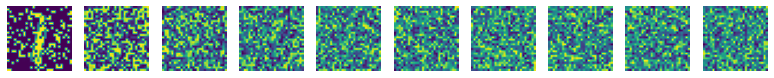

In [ ]:
images = next(iter(train_data))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = time_steps_number // num_images

for idx in range(0, time_steps_number, stepsize):
    images = images[:1]
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, (idx/stepsize) + 1)
    plt.axis('off')
    noised = f_model.forward(images, t)
    show_tensor_image(noised)

## Step 2: The backward process = U-Net


In [ ]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embeddings = []
    half_d = d // 2
    for i in range(n):
        embeddings.append([i / 10000 ** (2 * j / d) for j in range(half_d)])
    embedding = torch.tensor(embeddings)

    embedding = torch.cat((embedding.sin(), embedding.cos()), dim=-1)

    return embedding

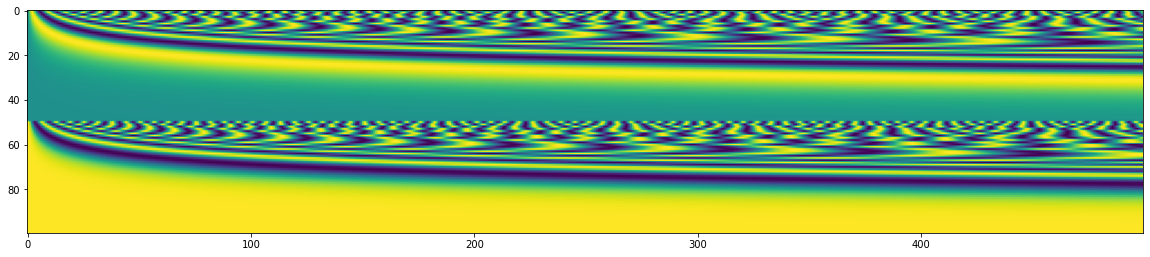

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
plt.imshow(sinusoidal_embedding(time_steps_number, 100).numpy().T)

## Loss

Noiseed input
![](https://s0.wp.com/latex.php?latex=%5Cdisplaystyle+x_t+%3D++%5Csqrt%7B%5Coverline%7B%5Calpha%7D_t%7Dx_0+%2B+%281-%5Coverline%7B%5Calpha%7D_t%29+%5Cvarepsilon%2C+%5Cquad++%5Cvarepsilon+%5Csim+%5Cmathcal%7BN%7D%280%2C+%5Cmathbf%7BI%7D%29++&bg=ffffff&fg=000000&s=1&c=20201002&zoom=3)


Loss

![](https://s0.wp.com/latex.php?latex=%5Cbegin%7Baligned%7D+%5Cdisplaystyle+L_%7B%5Cmathrm%7Bsimple%7D%7D+%28%5Ctheta%29+%26%3D+%5Cmathbb%7BE%7D_%7Bx_0%2C+%5Cvarepsilon%2C+t%7D+%5Cleft%5B+%5C%7C+%5Cvarepsilon_%5Ctheta%5Cleft%28x_t%2Ct%5Cright%29+-+%5Cvarepsilon%5C%7C%5E2%5Cright%5D+++%5C%5C+%26%3D+%5Cmathbb%7BE%7D_%7Bx_0%2C+%5Cvarepsilon%2C+t%7D+%5Cleft%5B+%5C%7C+%5Cvarepsilon_%5Ctheta%5Cleft%28%5Csqrt%7B%5Coverline%7B%5Calpha%7D_t%7Dx_0+%2B+%5Csqrt%7B1-%5Coverline%7B%5Calpha%7D%7D%5C%3B%5Cvarepsilon%2C+t%29%5Cright%29+-+%5Cvarepsilon%5C%7C%5E2%5Cright%5D++%5Cend%7Baligned%7D++&bg=ffffff&fg=000000&s=1&c=20201002&zoom=3)

In [ ]:
class DDPM(nn.Module):
    def __init__(self, time_steps_number, f_model, device):
        super(DDPM, self).__init__()
        self.n_steps = time_steps_number
        self.device = device
        self.f_model = f_model
        self.network = MyUNet(time_steps_number, 100).to(device)
        self.mse = nn.MSELoss()

    def forward(self, x0, t, eta=None):
        return self.f_model.forward(x0, t, eta)

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)

    def loss(self, x0, time_step):
        batch_size = len(x0)
        # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
        eta = torch.randn_like(x0).to(self.device)

        # Computing the noisy image based on x0 and the time-step (forward process)
        noisy_imgs = self.f_model.forward(x0, time_step, eta)

        # Getting model estimation of noise based on the images and the time-step
        eta_theta = self.backward(noisy_imgs, time_step.reshape(batch_size, -1))

        # Optimizing the MSE between the noise plugged and the predicted noise
        return self.mse(eta_theta, eta)

In [ ]:
class UNetBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(UNetBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU()
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [ ]:
class MyUNet(nn.Module):
    def __init__(self, time_steps_number, time_emb_dim):
        super(MyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(time_steps_number, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(time_steps_number, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self.make_te_layer(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            UNetBlock((1, 28, 28), 1, 10),
            UNetBlock((10, 28, 28), 10, 10),
            UNetBlock((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self.make_te_layer(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            UNetBlock((10, 14, 14), 10, 20),
            UNetBlock((20, 14, 14), 20, 20),
            UNetBlock((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self.make_te_layer(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            UNetBlock((20, 7, 7), 20, 40),
            UNetBlock((40, 7, 7), 40, 40),
            UNetBlock((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self.make_te_layer(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            UNetBlock((40, 3, 3), 40, 40),
            UNetBlock((40, 3, 3), 40, 40),
            UNetBlock((40, 3, 3), 40, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self.make_te_layer(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            UNetBlock((80, 7, 7), 80, 40),
            UNetBlock((40, 7, 7), 40, 20),
            UNetBlock((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self.make_te_layer(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            UNetBlock((40, 14, 14), 40, 20),
            UNetBlock((20, 14, 14), 20, 10),
            UNetBlock((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self.make_te_layer(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            UNetBlock((20, 28, 28), 20, 10),
            UNetBlock((10, 28, 28), 10, 10),
            UNetBlock((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t_e):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t_e = self.time_embed(t_e)
        n = len(x)
        out1 = self.b1(x + self.te1(t_e).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t_e).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t_e).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t_e).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t_e).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t_e).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t_e).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

    def make_te_layer(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

In [ ]:
SEED = 12345
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    plt.subplots_adjust(hspace=0.02, wspace=0.02)

    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.axis("off")
                plt.imshow(images[idx][0], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=24)

    # Showing the figure
    plt.show()

In [ ]:
def show_first_batch(loader):
    batch = next(iter(loader))
    show_images(batch[0], "Images in the first batch")

In [ ]:
def show_forward(ddpm, loader, device):
    batch = next(iter(loader))

    # Showing the forward process
    imgs = batch[0]

    show_images(imgs, "Original images")

    for percent in [0.25, 0.5, 0.75, 1]:
        show_images(
            ddpm(imgs.to(device),
                 [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]),
            f"DDPM Noisy images {int(percent * 100)}%"
        )

In [ ]:
def normalize_image(x):
    normalized = x.clone()
    for i in range(len(normalized)):
        normalized[i] -= torch.min(normalized[i])
        normalized[i] *= 255 / torch.max(normalized[i])

    return normalized

In [ ]:
def generate_new_images(ddpm, n_samples=25, device=None, initial_data=None):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    c = 1
    h = 28
    w = 28

    with torch.no_grad():
        # Starting from random noise
        if initial_data is None:
            x = torch.randn(n_samples, c, h, w).to(device)
        else:
            x = initial_data

        down_steps = list(range(ddpm.n_steps))[::-1]
        for idx, t in enumerate(down_steps):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.f_model.alphas[t]
            alpha_t_bar = ddpm.f_model.alpha_bars[t]

            shift = (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta
            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - shift)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                beta_t = ddpm.f_model.betas[t]
                sigma_t = beta_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z

    return x

In [ ]:
def add_frame(frames, n_samples, x):
    # Putting digits in range [0, 255]
    normalized = normalize_image(x)
    # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
    frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
    frame = frame.cpu().numpy().astype(np.uint8)
    # Rendering frame
    frames.append(frame)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
time_steps_number = 1000
min_beta = 10 ** -4
max_beta = 0.02  # Originally used by the authors

f_model = ForwardModel(min_beta=min_beta, max_beta=max_beta, time_steps_number=time_steps_number, device=device)

model = DDPM(time_steps_number=time_steps_number, f_model=f_model, device=device)

In [ ]:
n_epochs = 20
lr = 0.001

optim = Adam(model.parameters(), lr)

Training progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/469 [00:00<?, ?it/s]

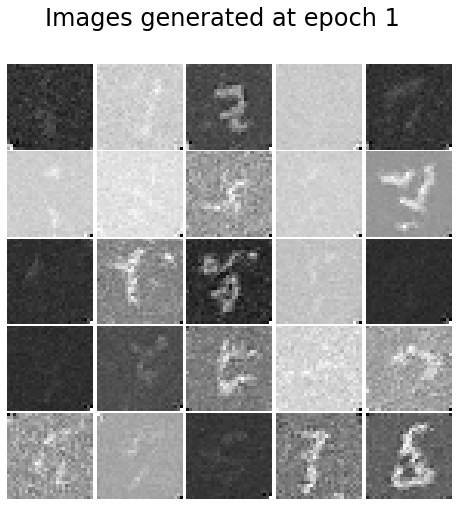

Loss at epoch 1: 0.167


Epoch 2/20:   0%|          | 0/469 [00:00<?, ?it/s]

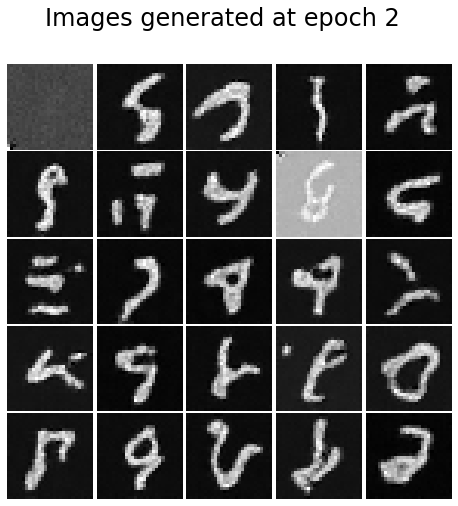

Loss at epoch 2: 0.047


Epoch 3/20:   0%|          | 0/469 [00:00<?, ?it/s]

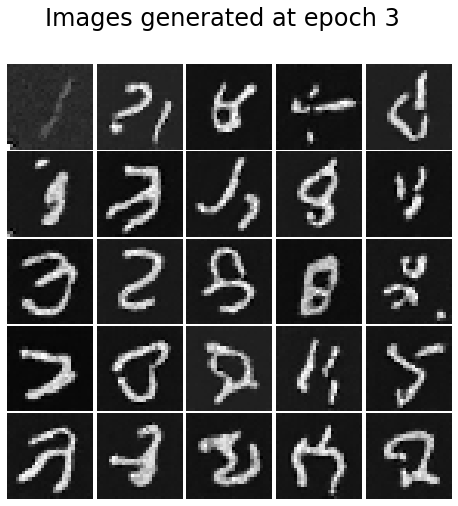

Loss at epoch 3: 0.042


Epoch 4/20:   0%|          | 0/469 [00:00<?, ?it/s]

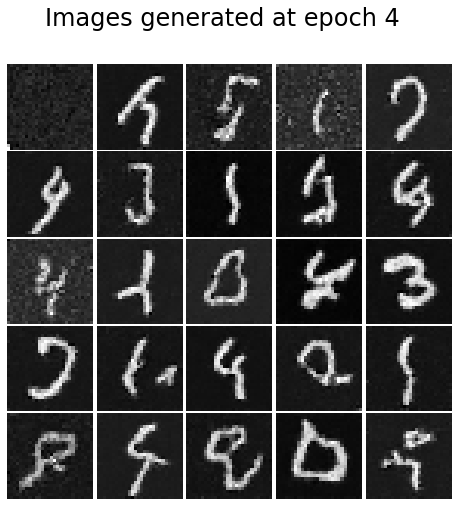

Loss at epoch 4: 0.038


Epoch 5/20:   0%|          | 0/469 [00:00<?, ?it/s]

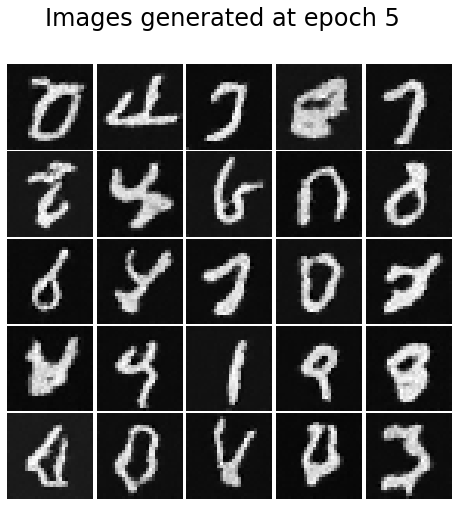

Loss at epoch 5: 0.037


Epoch 6/20:   0%|          | 0/469 [00:00<?, ?it/s]

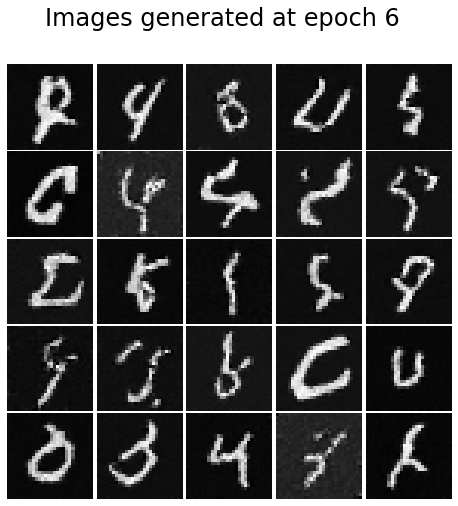

Loss at epoch 6: 0.035


Epoch 7/20:   0%|          | 0/469 [00:00<?, ?it/s]

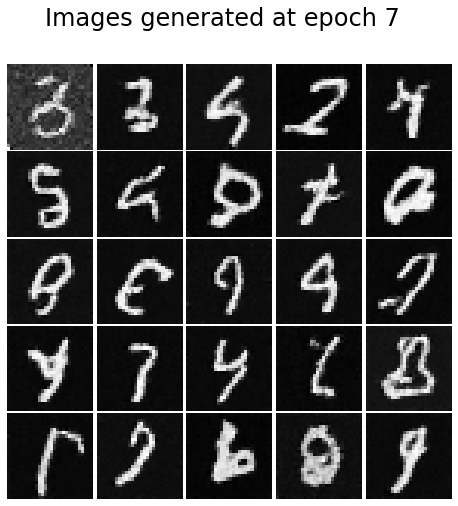

Loss at epoch 7: 0.034


Epoch 8/20:   0%|          | 0/469 [00:00<?, ?it/s]

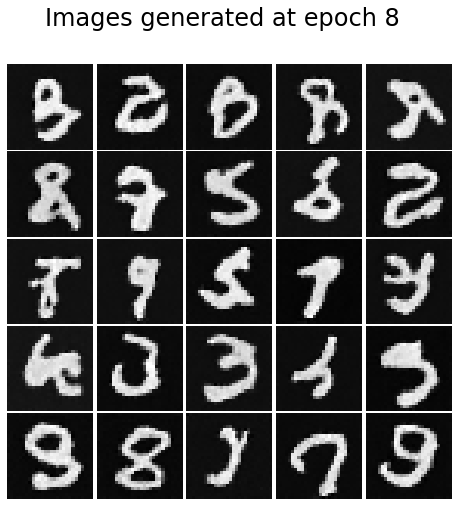

Loss at epoch 8: 0.034


Epoch 9/20:   0%|          | 0/469 [00:00<?, ?it/s]

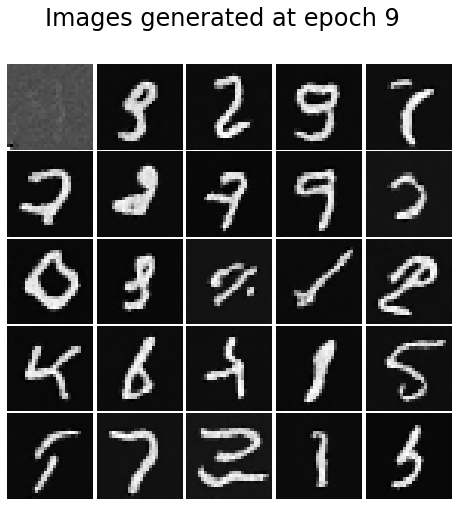

Loss at epoch 9: 0.033


Epoch 10/20:   0%|          | 0/469 [00:00<?, ?it/s]

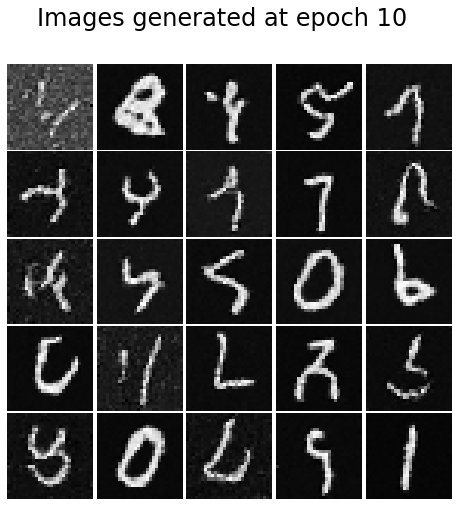

Loss at epoch 10: 0.032


Epoch 11/20:   0%|          | 0/469 [00:00<?, ?it/s]

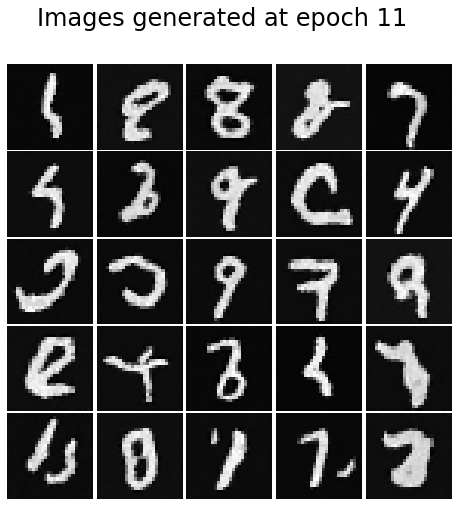

Loss at epoch 11: 0.033


Epoch 12/20:   0%|          | 0/469 [00:00<?, ?it/s]

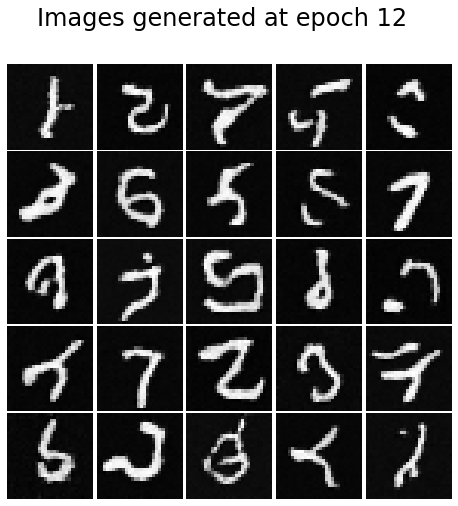

Loss at epoch 12: 0.032


Epoch 13/20:   0%|          | 0/469 [00:00<?, ?it/s]

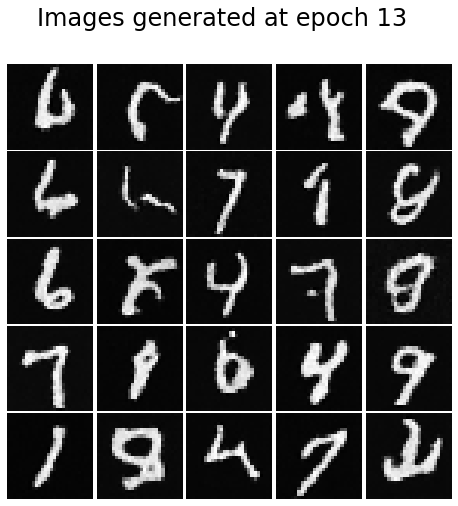

Loss at epoch 13: 0.031


Epoch 14/20:   0%|          | 0/469 [00:00<?, ?it/s]

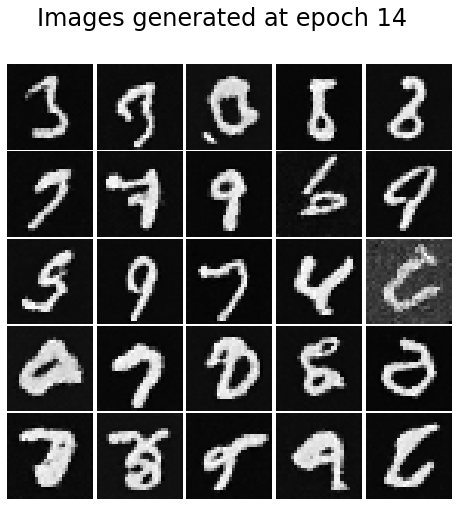

Loss at epoch 14: 0.031


Epoch 15/20:   0%|          | 0/469 [00:00<?, ?it/s]

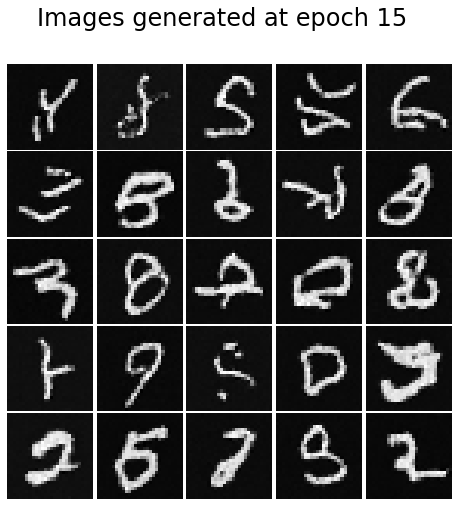

Loss at epoch 15: 0.031


Epoch 16/20:   0%|          | 0/469 [00:00<?, ?it/s]

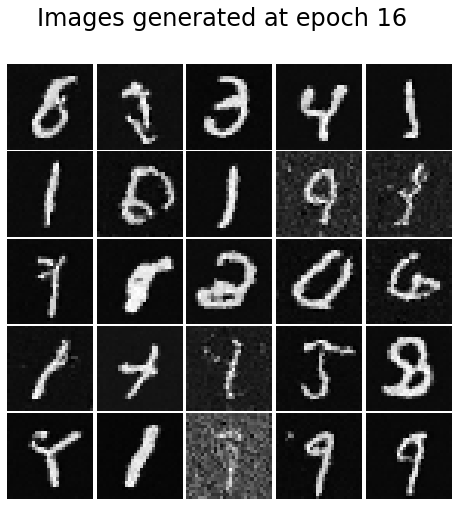

Loss at epoch 16: 0.031


Epoch 17/20:   0%|          | 0/469 [00:00<?, ?it/s]

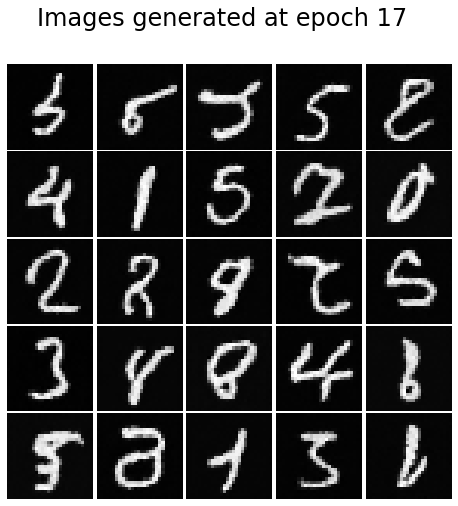

Loss at epoch 17: 0.030


Epoch 18/20:   0%|          | 0/469 [00:00<?, ?it/s]

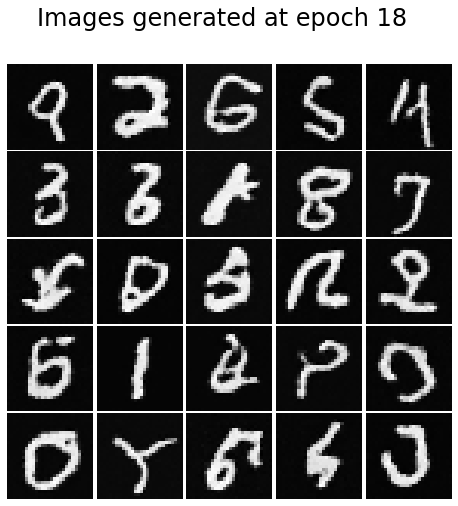

Loss at epoch 18: 0.030


Epoch 19/20:   0%|          | 0/469 [00:00<?, ?it/s]

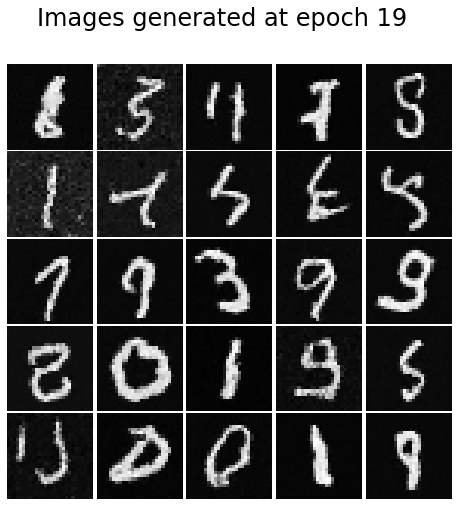

Loss at epoch 19: 0.029


Epoch 20/20:   0%|          | 0/469 [00:00<?, ?it/s]

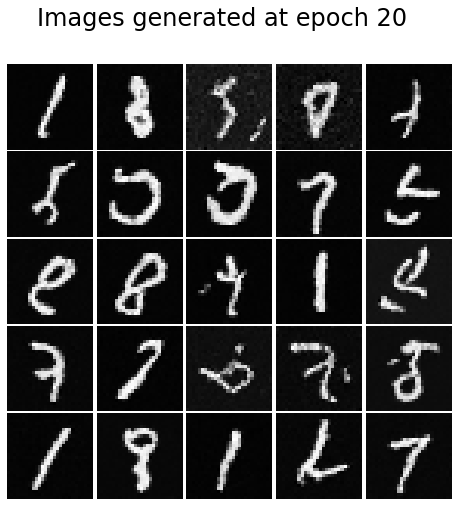

Loss at epoch 20: 0.029


In [ ]:
n_steps = model.n_steps
n_epochs=20


n_samples = 25 
x_start = torch.randn(n_samples, 1, 28, 28).to(device)

for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
    epoch_loss = 0.0
    for batch in tqdm(train_data, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}"):
        # Loading data
        x0, x0_class = batch
        x0 = x0.to(device)
        x0_class = x0_class.to(device)

        batch_size = len(x0)

        time_step = torch.randint(0, n_steps, (batch_size,)).to(device)

        loss = model.loss(x0, time_step)
        optim.zero_grad()
        loss.backward()
        optim.step()

        epoch_loss += loss.item() * len(x0) / len(train_data.dataset)

    show_images(generate_new_images(model, n_samples, device=device, initial_data=x_start), f"Images generated at epoch {epoch + 1}")
    plt.show()

    print(f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}")
